# Fitting Bond Prices with Nelson Siegel and Nelson Siegel Svensson models

The Nelson-Siegel and its extension Nelson-Siegel-Svensson are two of the most popular yield curve models.

They are very useful when we do not have nicely spaced bond quotes data to build the discounting factors from.

Sometimes up until certain maturities there are two many bonds compared with the number of maturities, and not sufficiently bonds thereafter. Very often, there are multiple bonds maturing in the same months.

From the discounting factor 

\begin{equation}
Z(0,t) =  exp^{-r(0,t)t}
\end{equation}

we can postulate a parametric function for the zero rate  $r(0,t)$, and use bond prices to estimate those parameters.

In the Nelson Siegel and  Nelson Siegel Svensson models, the zero rate respectively follows the parametric equations:

\begin{equation} Nelson\ Siegel :\  
r(0,t) = \beta_0 + \beta_1\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} \right) + \beta_2\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} - e^{\frac{-t}{T_1}} \right) \end{equation}

\begin{equation} Nelson\ Siegel\ Svensson :\
r(0,t) = \beta_0 + \beta_1\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} \right) + \beta_2\left(\frac{1-e^{\left(\frac{-t}{T_1}\right)}}{t/T_1} - e^{\frac{-t}{T_1}} \right) + 
\beta_3 \left( \frac{1-e^{\left(\frac{-t}{T_2}\right)}}{t/T_2} -e^{\frac{-t}{T_2}} \right)
\end{equation}

where:

-  $r(0,t)$: zero rate with maturity $t$
-  $\beta_0$: level parameter, the long term rate
-  $\beta_1$: slope parameter, the spread short/long-term
-  $\beta_2$: first curvature or hump parameter
-  $\beta_3$: second curvature or hump parameter which allows for a better fit at long maturities

-  $T_1$: scale parameter which affects both the slope and first curvature $\beta_1$ and $\beta_2$
-  $T_2$: scale parameter for the second hump parameter $\beta_3$

where $T_2$ and $\beta_3$ are only valid for the NSS model.  

The way we proceed is by selecting the given set of parameters which minimizes the following quantity

$$ \sum_{i=1}^{N}\left(P^{i,Model}(0,t)-P^{i}(0,t)\right) $$


where:

$P^{i,Model}(0,t)$  is the discounted value of the bond $i$ cash flows calculated with either NS or NSS models and

$P^{i}(0,t)$ is dirty price (quoted clean price + accrued interest) of the same bond $i$

$N$ is the number of bonds with quotes

In this notebook, we want to try to calibrate the NS and NSS parameters to a set of bond prices made available to us. The prices are old, as they date back to december 1st 2000. They were collected from Fixed Income Securities, Pietro Veronesi, page 319, table 8.8. http://pietroveronesi.org/teaching/FIS/

We are going to use the minimize object available in python via the library "scipy.optimize".

One warning: When working on a different dataset of bond prices you may find the calibration results at least initially, poor. This is due to the starting values. Start with fitting the Nelson Siegel, and once you are happy, move to the Nelson Siegel Svensson. 

We start by importing the python libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

Let's import our data set:

CashFlows and Prices

In [2]:
CashFlows = pd.read_excel ('BondPrices_DB.xlsx', sheet_name='CashFlows')
print (CashFlows.head(2))
print (CashFlows.tail(2))

        Time  Bond1  Bond2  Bond3  Bond4  Bond5  Bond6  Bond7  Bond8  Bond9  \
0 2000-12-02      0      0      0      0      0      0      0      0      0   
1 2000-12-03      0      0      0      0      0      0      0      0      0   

    ...     Bond120  Bond121  Bond122  Bond123  Bond124  Bond125  Bond126  \
0   ...           0      0.0      0.0      0.0      0.0      0.0      0.0   
1   ...           0      0.0      0.0      0.0      0.0      0.0      0.0   

   Bond127  Bond128  Bond129  
0      0.0      0.0      0.0  
1      0.0      0.0      0.0  

[2 rows x 130 columns]
          Time  Bond1  Bond2  Bond3  Bond4  Bond5  Bond6  Bond7  Bond8  Bond9  \
211 2029-02-15      0      0      0      0      0      0      0      0      0   
212 2029-08-15      0      0      0      0      0      0      0      0      0   

       ...     Bond120  Bond121  Bond122  Bond123  Bond124  Bond125  Bond126  \
211    ...           0      0.0      0.0      0.0      0.0      0.0      0.0   
212    ..

Please also note that the time when bonds cash flows occur are not at constant intervals  

In [3]:
row, col = CashFlows.shape
print (row)
print (col)
# there are 129 bonds (columns), with 213 cash flows items (rows) 

213
130


In [4]:
# In this print: the first two bonds are Zero Coupon Bonds, whereas the last two are Coupon Bonds
BondPrices = pd.read_excel (r'BondPrices_DB.xlsx', sheet_name='Prices')
print (BondPrices.head(2))
print (BondPrices.tail(2))

    Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity
0  Bond1    99.897834    99.897834              0.0     0.0 2000-12-07
1  Bond2    99.783604    99.783604              0.0     0.0 2000-12-14
        Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity
127  Bond128    94.943105    93.402344         1.540761   5.250 2029-02-15
128  Bond129   107.766304   105.968750         1.797554   6.125 2029-08-15


In [5]:
print (BondPrices.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
Name               129 non-null object
Dirty Price        129 non-null float64
Clean Price        129 non-null float64
AccruedInterest    129 non-null float64
Coupon             129 non-null float64
Maturity           129 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 6.1+ KB
None


We need to add a column for the time lapsing from "today" which is 1st of December 2000 until the bond pays a coupon or matures

In [6]:
from datetime import date
first_date = date(2000, 12, 1)
CashFlows["timeDiff"] = (CashFlows["Time"] - first_date)
CashFlows["timeDiff"] = CashFlows["timeDiff"]/np.timedelta64(1,'D')
CashFlows["timeDiff"] = CashFlows["timeDiff"]/365.0
print (CashFlows.head(4))

        Time  Bond1  Bond2  Bond3  Bond4  Bond5  Bond6  Bond7  Bond8  Bond9  \
0 2000-12-02      0      0      0      0      0      0      0      0      0   
1 2000-12-03      0      0      0      0      0      0      0      0      0   
2 2000-12-04      0      0      0      0      0      0      0      0      0   
3 2000-12-05      0      0      0      0      0      0      0      0      0   

     ...     Bond121  Bond122  Bond123  Bond124  Bond125  Bond126  Bond127  \
0    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3    ...         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   Bond128  Bond129  timeDiff  
0      0.0      0.0  0.002740  
1      0.0      0.0  0.005479  
2      0.0      0.0  0.008219  
3      0.0      0.0  0.010959  

[4 rows x 131 columns]


From the BondPrices and CashFlows dataframes, we respectively need "Dirty Prices", "timeDiff" and all Cash Flows.

Let's import them into numpy arrays and also check they have the correct dimension

In [7]:
DirtyPrices= BondPrices["Dirty Price"].values
Maturities = BondPrices["Dirty Price"].values
TimeValue  = CashFlows["timeDiff"].values
CFs        = CashFlows[CashFlows.columns[1:130]].values

In [8]:
print (DirtyPrices.size)
print (TimeValue.size)
print (CFs.shape)

129
213
(213, 129)


They have the right size: There are 129 bonds with 213 cash flows. Some bonds have coupon payments occuring on the same date  

In case you want to see cash flows in an excel sheet, run this 

In [9]:
df = pd.DataFrame(CFs)
df.to_csv('Cashflows.csv')

We also calculate the YTM for each bond. We will need it later.  

Let's write a class to do that. 

In [10]:
class YTM(object):
    def __init__(self, DirtyPrice, times, CFs):
        self.times     = np.array(times)
        self.CFs       = np.array(CFs)
        self.size      = self.times.size
        self.DirtyPrice= DirtyPrice 
        self.df        = np.zeros(self.size)
        self.ytm       = 0.0
        
    def DF(self, ytm):
        for i, j in enumerate (self.times):
            self.df[i] = (1+ytm/2.0)**(-j * 2.0)
    
    def MyDirtyPrice(self):
        self.my_dirtyprice = self.df.dot(self.CFs)
    
    def loss(self, x):
        self.x = x
        self.DF(self.x)
        self.MyDirtyPrice()
        Tominimize      = 1000*(self.my_dirtyprice - self.DirtyPrice)
        return Tominimize**2
        
    def solve(self,x0 = np.random.rand(1)):
        self.opt_results = optimize.fmin(self.loss,x0=x0, disp=False)
        self.x           = self.opt_results[0]

Let's test the YTM class on the last bond on our dataset

In [11]:
# The cash flows and price are the following
print (DirtyPrices[128])
print (CFs[:, 128])

107.7663043478261
[  0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       3.0625   0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       3.0625
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       3.0625   0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       3.0625   0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       3.0625
   0.       0.       0.       0.       0.       0.       0.       0.
   3.0625   0.       0.       0.       3.0625   0.       0.       0.
   3.0625   0.       0.       0.       3.0625   0.       0.       0.
   3.062

In [12]:
ytm = YTM(DirtyPrices[128], TimeValue, CFs[:, 128])
ytm.solve()
print (ytm.x)
print (ytm.my_dirtyprice)
print (DirtyPrices[128])

0.05696127844123905
107.76631622264058
107.7663043478261


Now for each bond, we calculate the YTM, given its Dirty Price

In [13]:
ytmArray       = np.zeros(DirtyPrices.size)
DirtyPrice_ytm = np.zeros(DirtyPrices.size)
for i in range(DirtyPrices.size):    
    ytm               = YTM(DirtyPrices[i], TimeValue, CFs[:, i])
    ytm.solve()
    ytmArray[i]       = (ytm.x)
    DirtyPrice_ytm[i] = (ytm.my_dirtyprice)

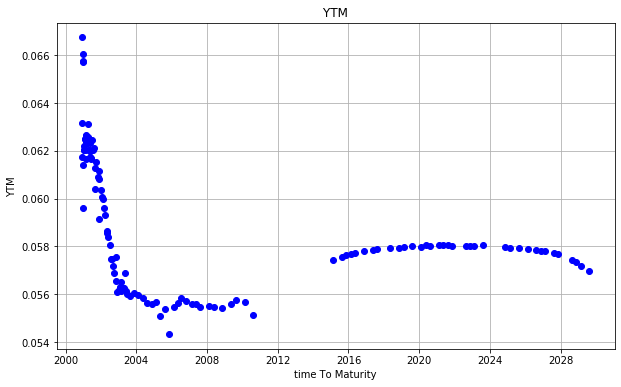

In [14]:
plt.figure(figsize=(10,6))
plt.plot(BondPrices["Maturity"], ytmArray, 'bo')
plt.xlabel('time To Maturity')  
plt.ylabel('YTM')
plt.grid(True)
plt.title(" YTM ");
plt.show()

Let's add ytm's and Dirty Price (calculated with ytm) into the "BondPrices" dataframe and check they are all ok

In [15]:
BondPrices["YTM"]            = ytmArray
BondPrices["DirtyPrice_YTM"] = DirtyPrice_ytm

In [16]:
'''
Are there any error?
No! The DirtyPrice_YTM, calculated by discounting the bond cash flows with the ytm just
calculated, should return the same Dirty Price!  
'''
print (np.round((np.sum(BondPrices["DirtyPrice_YTM"] - BondPrices["Dirty Price"])),5))

-2e-05


In [17]:
print (BondPrices.head(2))
print (BondPrices.tail(2))

    Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity  \
0  Bond1    99.897834    99.897834              0.0     0.0 2000-12-07   
1  Bond2    99.783604    99.783604              0.0     0.0 2000-12-14   

        YTM  DirtyPrice_YTM  
0  0.063163       99.897828  
1  0.061759       99.783614  
        Name  Dirty Price  Clean Price  AccruedInterest  Coupon   Maturity  \
127  Bond128    94.943105    93.402344         1.540761   5.250 2029-02-15   
128  Bond129   107.766304   105.968750         1.797554   6.125 2029-08-15   

          YTM  DirtyPrice_YTM  
127  0.057198       94.943100  
128  0.056961      107.766316  


Let's write a class for the Nelson Siegel Svensson algo

In [18]:
class NelsonSiegelModels(object):
    def __init__(self, size):
        self.r         = np.zeros(size)
        self.df        = np.zeros(size)
            
    def Load_CF_Prices(self,time_, Cashflows_, Prices_):
        self.time      = np.asarray(time_)
        self.Cashflows = np.asarray(Cashflows_)
        self.Prices    = np.asarray(Prices_)
    
    def set_ws(self,w_):
        pass
    
    def set_NL(self,NL_):
        pass
        
    def set_NL0(self,NL_):
        pass

    def set_NL1(self,NL_):
        pass

    def DF(self):
        self.df = np.exp(-self.r * self.time)        
        
    def zerorate(self, t):
        pass
  
    def ols(self, t):        
        pass
    
    def Zerorates(self):
        t      = self.time        
        vfunc = np.vectorize(self.zerorate)        
        self.r = vfunc(t)
    
    def loss(self, w):
        self.w = w
        self.Zerorates()
        self.DF()       
        Ax     = np.transpose(self.df).dot(self.Cashflows)
        error  = (self.Prices - Ax)**2                
        return np.mean(error)
    
    def Calibrate(self, initialguess):
        self.opt_results = optimize.minimize(self.loss,np.array(initialguess),jac=False,tol=1e-13,method='L-BFGS-B')
        self.w           = self.opt_results.x 

In [19]:
class NelsonSiegelSvensson(NelsonSiegelModels):
    def __init__(self, size):
        NelsonSiegelModels.__init__(self, size)
        self.NL  = np.zeros(2)
        self.w   = np.zeros(4)
    
    def set_ws(self,w_):
        self.w = w_
    
    def set_NL0(self,NL_):
        self.NL[0] = NL_

    def set_NL1(self,NL_):
        self.NL[1] = NL_
   
    def zerorate(self, t):
        vec = self.ols(t)        
        return self.w[0]*vec[0] + self.w[1] * vec[1] + self.w[2] * vec[2] + self.w[3] * vec[3]
    
    def ols(self, t):        
        a = 1.0
        b = ( (1-np.exp(-t/self.NL[0])) / (t/self.NL[0]))
        c = ( (1-np.exp(-t/self.NL[0])) / (t/self.NL[0]) - np.exp(-t/self.NL[0]) ) 
        d = ( (1-np.exp(-t/self.NL[1])) / (t/self.NL[1]) - np.exp(-t/self.NL[1]) )
        return np.asarray([a, b, c, d])

In [20]:
# and let's do the same for the Nelson Siegel algo
class NelsonSiegel(NelsonSiegelModels):
    def __init__(self, size):
        NelsonSiegelModels.__init__(self, size)
        self.NL  = np.zeros(1)
        self.w   = np.zeros(3)
            
    def set_ws(self, w_):
        self.w = w_
        
    def set_NL(self,NL_):
        self.NL = [NL_]
                
    def zerorate(self, t):        
        vec = self.ols(t)
        return self.w[0] * vec[0] + self.w[1] * vec[1] + self.w[2] * vec[2]
    
    def ols(self, t):
        a = 1.0
        b = ( (1-np.exp(-t/self.NL[0])) / (t/self.NL[0]) )
        c = ( (1-np.exp(-t/self.NL[0])) / (t/self.NL[0]) - np.exp(-t/self.NL[0]))        
        return np.asarray([a, b, c])

Let's check the class NelsonSiegelSvensson works.

1 - We instantiate an object of type "NelsonSiegelSvensson"

2 - We load a set of parameters

3 - We print the zero rate with a maturity of 1 year and 30 year

4 - we run the methods: Zerorates() and DF()

5 - and then multiply the object df by Cashflows. This should calculate Dirty Prices which we can compare with the Dirty Prices in our dataframe "BondPrices"

In [21]:
len(TimeValue)

213

In [22]:
# 1
nss = NelsonSiegelSvensson(len(TimeValue))
nss.Load_CF_Prices(TimeValue, CFs, DirtyPrices )
# 2
nss.set_ws([0.06,-0.05,-.2,0.21])
nss.set_NL0(1.0)
nss.set_NL1(1.0)

# 3
print (nss.zerorate(1))
print (nss.zerorate(30))

0.03103638323514326
0.058666666666665854


In [23]:
# 4 
nss.Zerorates()
nss.DF()

# 5
Ax  = np.transpose(nss.df).dot(nss.Cashflows)
BondPrices["DirtyPrice_NSS"] = Ax

In [24]:
# What it the error sum of the differences?
print (np.round((np.sum(BondPrices["DirtyPrice_NSS"] - BondPrices["Dirty Price"])),5))

188.58183


CAN WE DO BETTER?

You might have noticed but when we instantiated the classes NelsonSiegelSvensson and NelsonSiegel, we set $T1$ and $T2$ to 1!

First we try to "do better" by keeping $T1$ and $T2$ at 1!

In [25]:
nss.set_NL0(1.0)
nss.set_NL1(1.0)
nss.Calibrate([0.06,-0.05, -0.2,0.21])

ns = NelsonSiegel(len(TimeValue))
ns.Load_CF_Prices(TimeValue, CFs, DirtyPrices )
ns.set_NL(1.0)
ns.Calibrate([0.06, -0.05, -0.20]) 

To print both NS and NSS parameters. We also use a function to apply print options locally

In [26]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

xss = nss.w
with printoptions(precision=3, suppress=True):
    print(xss)
    
xs = ns.w
with printoptions(precision=3, suppress=True):
    print(xs)    

[ 0.058  0.015 -0.221  0.189]
[ 0.058  0.015 -0.033]


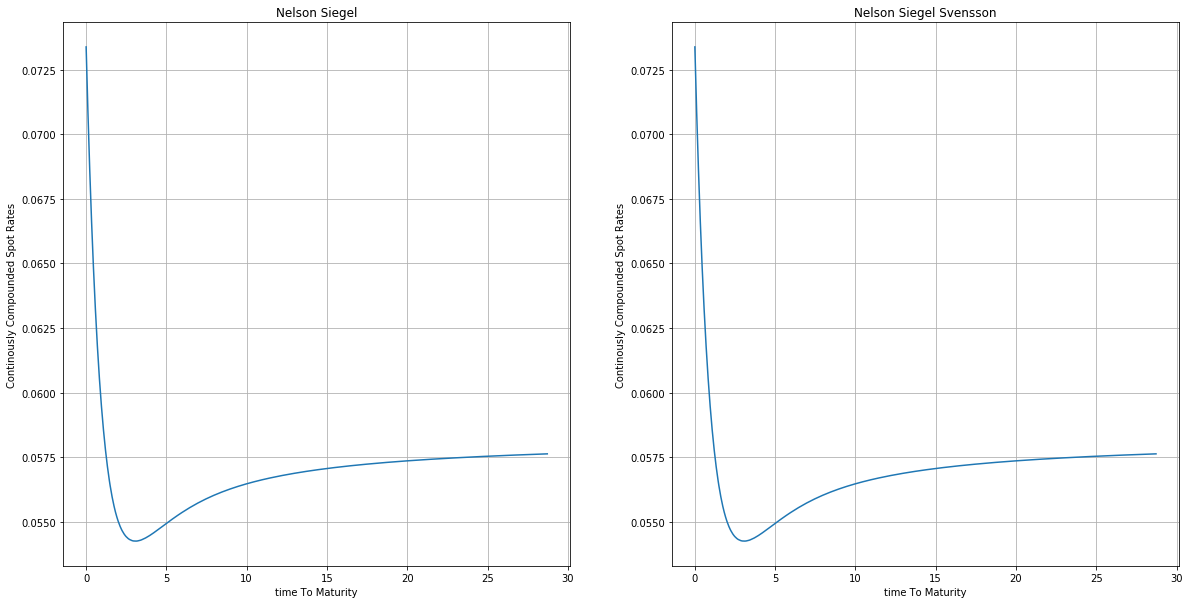

In [27]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(ns.time, ns.r, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot Rates')
plt.grid(True)
plt.title("Nelson Siegel");

plt.subplot(1, 2, 2)
plt.plot(nss.time, nss.r, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot Rates')
plt.grid(True)
plt.title("Nelson Siegel Svensson");

plt.show()

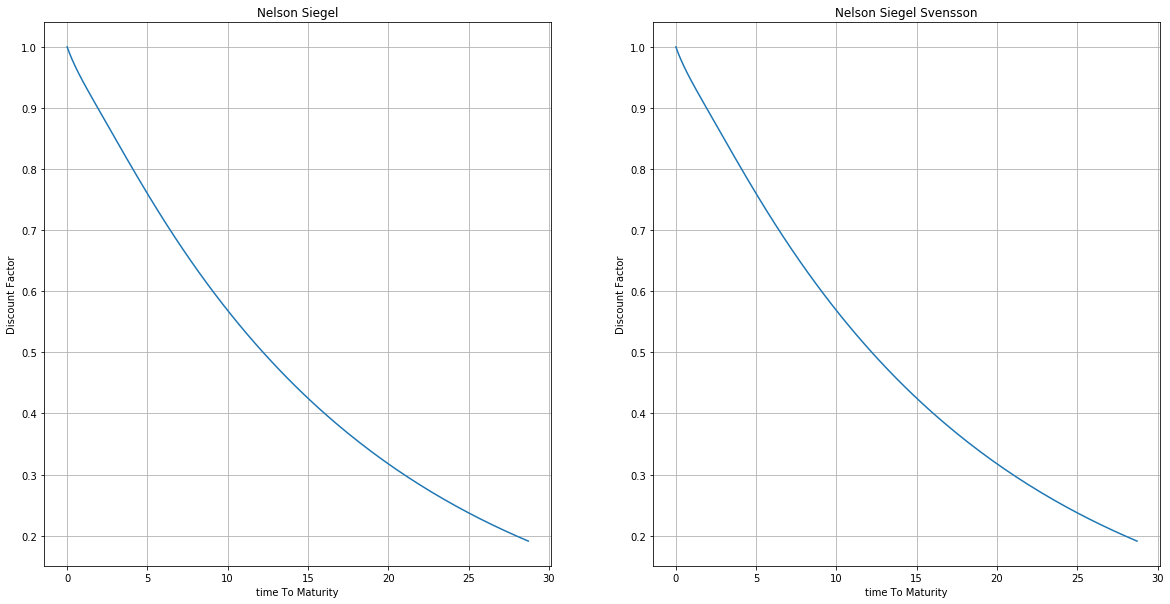

In [28]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(ns.time, ns.df, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Discount Factor')
plt.grid(True)
plt.title("Nelson Siegel");

plt.subplot(1, 2, 2)
plt.plot(nss.time, nss.df, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Discount Factor')
plt.grid(True)
plt.title("Nelson Siegel Svensson");

plt.show()

In [29]:
# Have we done better than before?
Ax_nss = np.transpose(nss.df).dot(nss.Cashflows)
Ax_ns  = np.transpose(ns.df).dot(ns.Cashflows)

BondPrices["DirtyPrice_NSS"] = Ax_nss
BondPrices["DirtyPrice_NS"]  = Ax_ns
BondPrices["CleanPrice_NSS"] = BondPrices["DirtyPrice_NSS"] -  BondPrices["AccruedInterest"]  
BondPrices["CleanPrice_NS"]  = BondPrices["DirtyPrice_NS"]  -  BondPrices["AccruedInterest"]  
BondPrices["CleanPrice_Diff_NSS"] = BondPrices["CleanPrice_NSS"] -  BondPrices["Clean Price"]
BondPrices["CleanPrice_Diff_NS"]  = BondPrices["CleanPrice_NS"]  -  BondPrices["Clean Price"]
print (np.round((np.sum(BondPrices["DirtyPrice_NSS"] - BondPrices["Dirty Price"])),5))
print (np.round((np.sum(BondPrices["DirtyPrice_NS"]  - BondPrices["Dirty Price"])),5))
# Yes!!

-5.45693
-5.45693


In [30]:
print (np.max(BondPrices["CleanPrice_Diff_NSS"]))
print (np.min(BondPrices["CleanPrice_Diff_NSS"]))
print (np.max(BondPrices["CleanPrice_Diff_NS"]))
print (np.min(BondPrices["CleanPrice_Diff_NS"]))

0.5030744034967825
-1.4936722969883363
0.5030749157424168
-1.4936712689438991


Not Bad so far!

Let's now try to optimize both NS and NSS model with different starting values for $T1$ and $T2$. 

We hope to be able to run the final optimization and achieve better results. 

We begin with the NS algo

In [31]:
Size         = 100
xT1          = np.linspace(0.1, 5.0, num = Size)
yNsPriceDiff = np.zeros((Size,2))

for i, val in enumerate(xT1):
    ns.set_NL(val)
    ns.Calibrate([0.06, -0.05, -0.20])
    
    Ax_ns  = np.transpose(ns.df).dot(ns.Cashflows)    
    res    = np.mean((Ax_ns - BondPrices["Dirty Price"])**2)
    if (res> 0.0001):
        yNsPriceDiff[i,0] = res
        yNsPriceDiff[i,1] = val
    else:
        print("error on xT1 ", val)

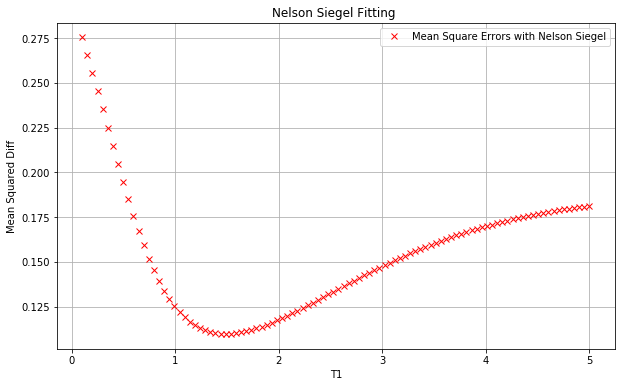

In [32]:
plt.figure(figsize=(10,6))
plt.plot(xT1, yNsPriceDiff[:,0], 'x', color='red', label ='Mean Square Errors with Nelson Siegel')
plt.legend()
plt.grid(True)
plt.ylabel('Mean Squared Diff')
plt.xlabel('T1')
plt.title("Nelson Siegel Fitting ");        
plt.show()

In [33]:
# Let's find the T1 value where we achieve the lowest Mean Square Error
minValue =  np.min(yNsPriceDiff[:,0])
index    =  np.where(yNsPriceDiff[:,0]== minValue)
valT1    =  yNsPriceDiff[index[0][0],1]
print(minValue)
print(valT1)

0.10974070069441773
1.4858585858585862


In [34]:
# And use it as a starting value again
ns.set_NL(valT1)
ns.Calibrate([0.06, -0.05, -0.20])

In [35]:
xs = ns.w
with printoptions(precision=3, suppress=True):
    print(xs)   

[ 0.059  0.008 -0.025]


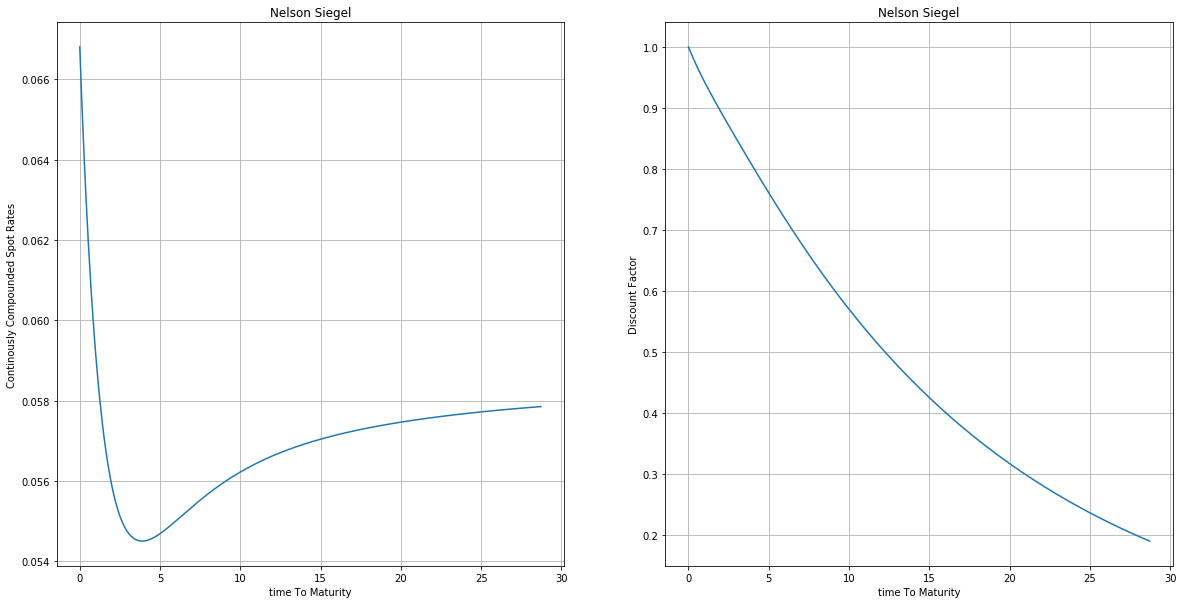

In [36]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(ns.time, ns.r, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot Rates')
plt.grid(True)
plt.title("Nelson Siegel");

plt.subplot(1, 2, 2)
plt.plot(ns.time, ns.df, lw=1.5)
plt.xlabel('time To Maturity')  
plt.ylabel('Discount Factor')
plt.grid(True)
plt.title("Nelson Siegel");

plt.show()

In [37]:
# Have we done better than before ?
Ax_ns  = np.transpose(ns.df).dot(ns.Cashflows)
BondPrices["DirtyPrice_NS"]  = Ax_ns
BondPrices["CleanPrice_NS"]  = BondPrices["DirtyPrice_NS"]  -  BondPrices["AccruedInterest"]  
BondPrices["CleanPrice_Diff_NS"]  = BondPrices["CleanPrice_NS"]  -  BondPrices["Clean Price"]
print (np.round((np.sum(BondPrices["DirtyPrice_NS"]  - BondPrices["Dirty Price"])),5))
# Yes!!

-3.90974


Let's do the same for the NSS model. As initial values we use the three betas of the NS model. We are still missing one, beta4. For this one we used 0.21   

In [38]:
beta_4 = 0.21 # this is the initial value
Size          = 100
xT2           = np.linspace(0.01, 20.0, num = Size)
yNssPriceDiff = np.zeros((Size,2))

for i, val in enumerate(xT2):
    nss.set_NL0(valT1)
    nss.set_NL1(val)
    nss.Calibrate(np.append(ns.w, beta_4))
    
    Ax_nss = np.transpose(nss.df).dot(nss.Cashflows)    
    res    = np.mean((Ax_nss - BondPrices["Dirty Price"])**2)
    if (res> 0.0001):
        yNssPriceDiff[i,0] = res
        yNssPriceDiff[i,1] = val
    else:
        print("error on xT2 ", val)

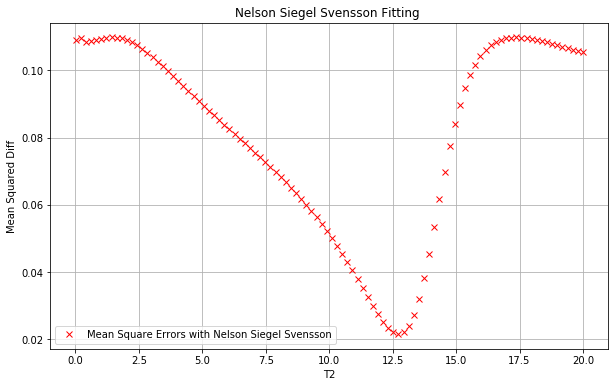

In [39]:
plt.figure(figsize=(10,6))
plt.plot(xT2, yNssPriceDiff[:,0], 'x', color='red', label ='Mean Square Errors with Nelson Siegel Svensson')
plt.legend()
plt.grid(True)
plt.ylabel('Mean Squared Diff')
plt.xlabel('T2')
plt.title("Nelson Siegel Svensson Fitting ");        
plt.show()

In [40]:
# Let's find the T1 value where we achieve the lowest Mean Square Error
minValue =  np.min(yNssPriceDiff[:,0])
index    =  np.where(yNssPriceDiff[:,0]== minValue)
valT2    =  yNssPriceDiff[index[0][0],1]
print(minValue)
print(valT2)

0.02160832348694625
12.73090909090909


In [41]:
# And use it as a starting value for T2 again, where for the other values we usewhat we found as "optimal" with the NS
nss.set_NL0(valT1)
nss.set_NL1(valT2)
nss.Calibrate(np.append(ns.w, 0.21))

In [42]:
xss = nss.w
with printoptions(precision=3, suppress=True):
    print(xss)   

[0.019 0.042 0.021 0.115]


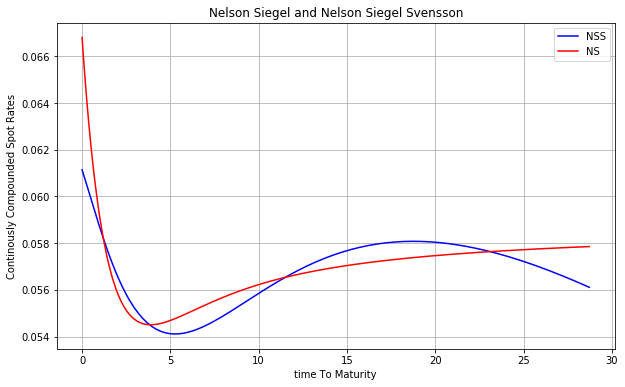

In [43]:
plt.figure(figsize=(10,6))
plt.plot(nss.time, nss.r, lw=1.5, color='blue', label ='NSS')
plt.plot(ns.time, ns.r, lw=1.5,   color='red', label ='NS')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot Rates')
plt.grid(True)
plt.title("Nelson Siegel and Nelson Siegel Svensson");
plt.show()

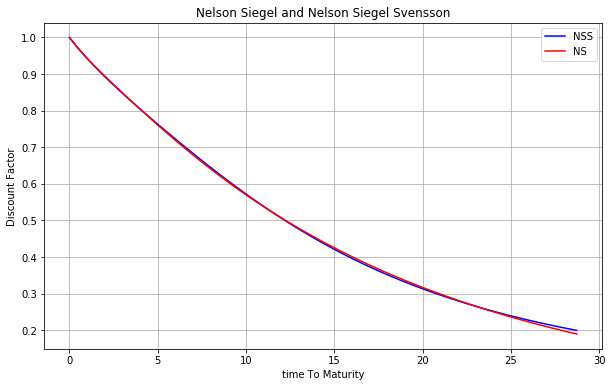

In [44]:
plt.figure(figsize=(10,6))
plt.plot(nss.time, nss.df, lw=1.5, color='blue', label ='NSS')
plt.plot(ns.time, ns.df, lw=1.5,   color='red', label ='NS')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Discount Factor')
plt.grid(True)
plt.title("Nelson Siegel and Nelson Siegel Svensson");
plt.show()


In [45]:
# Have we done better than with the NS model?
Ax_nss  = np.transpose(nss.df).dot(nss.Cashflows)
BondPrices["DirtyPrice_NSS"]  = Ax_nss
BondPrices["CleanPrice_NSS"]  = BondPrices["DirtyPrice_NSS"]  -  BondPrices["AccruedInterest"]  
BondPrices["CleanPrice_Diff_NSS"]  = BondPrices["CleanPrice_NSS"]  -  BondPrices["Clean Price"]
print (np.round((np.sum(BondPrices["DirtyPrice_NSS"]  - BondPrices["Dirty Price"])),5))
# Yes!!

0.61864


In [46]:
# Range between the min and max difference  
maxNSS = np.round(np.max(BondPrices["CleanPrice_Diff_NSS"]),3)
minNSS = np.round(np.min(BondPrices["CleanPrice_Diff_NSS"]),3)

maxNS = np.round(np.max(BondPrices["CleanPrice_Diff_NS"]),3)
minNS = np.round(np.min(BondPrices["CleanPrice_Diff_NS"]),3)

print ("NSS Range [",minNSS,";", maxNSS,"]")
print ("NS  Range [",minNS,";", maxNS,"]")

NSS Range [ -0.867 ; 0.389 ]
NS  Range [ -1.621 ; 0.516 ]


In [47]:
#let's print the fitted values for NSS model
NSS_Value = np.append(nss.w, [valT1, valT2])
with printoptions(precision=3, suppress=True):
    print(NSS_Value) 

# for NS model
NS_Value = np.append(ns.w, valT1)
with printoptions(precision=3, suppress=True):
    print(NS_Value) 

[ 0.019  0.042  0.021  0.115  1.486 12.731]
[ 0.059  0.008 -0.025  1.486]


Below, we compare the fitting achieved with both models. NSS does a better job!

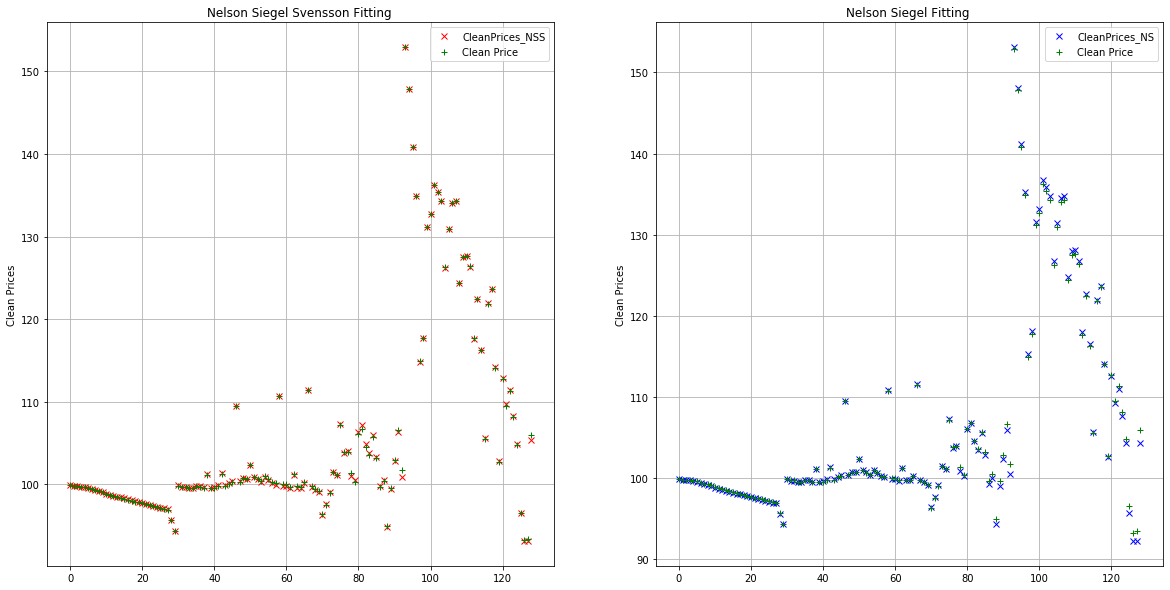

In [48]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(BondPrices["CleanPrice_NSS"],  'x', color='red', label ='CleanPrices_NSS')
plt.plot(BondPrices["Clean Price"],  '+', color='green'  ,label ='Clean Price')
plt.legend()
plt.grid(True)
plt.ylabel('Bond No.')
plt.ylabel('Clean Prices')
plt.title("Nelson Siegel Svensson Fitting ");        

plt.subplot(1, 2, 2)
plt.plot(BondPrices["CleanPrice_NS"],   'x', color='blue', label ='CleanPrices_NS')
plt.plot(BondPrices["Clean Price"],  '+', color='green'  ,label ='Clean Price')
plt.legend()
plt.grid(True)
plt.ylabel('Bond No.')
plt.ylabel('Clean Prices')
plt.title("Nelson Siegel Fitting ");        

plt.show()

Now we can sort the bonds by the cheapest and the most expensive, by comparing the Clean Price vs the one we calculated with the NSS algo, called CleanPrice_NSS. For example we may want to short the most expensive and buy the cheapest, if you believe in the NSS model! 

In [49]:
BondPrices.sort_values(by='CleanPrice_Diff_NSS',ascending=1).head(5)

,Name,Dirty Price,Clean Price,AccruedInterest,Coupon,Maturity,YTM,DirtyPrice_YTM,DirtyPrice_NSS,DirtyPrice_NS,CleanPrice_NSS,CleanPrice_NS,CleanPrice_Diff_NSS,CleanPrice_Diff_NS
92,Bond93,103.421875,101.734375,1.687500,5.750,2010-08-15,0.055137,103.421880,102.554426,102.202764,100.866926,100.515264,-0.867449,-1.219111
128,Bond129,107.766304,105.968750,1.797554,6.125,2029-08-15,0.056961,107.766316,107.191357,106.145729,105.393803,104.348174,-0.574947,-1.620576
78,Bond79,101.597894,101.343750,0.254144,5.750,2005-11-15,0.054336,101.597899,101.295672,101.086663,101.041528,100.832519,-0.302222,-0.511231
91,Bond92,108.505265,106.597656,1.907609,6.500,2010-02-15,0.055688,108.505277,108.208958,107.793823,106.301350,105.886214,-0.296306,-0.711442
127,Bond128,94.943105,93.402344,1.540761,5.250,2029-02-15,0.057198,94.943100,94.673024,93.756385,93.132264,92.215625,-0.270080,-1.186719


In [50]:
BondPrices.sort_values(by='CleanPrice_Diff_NSS',ascending=0).head(5)

,Name,Dirty Price,Clean Price,AccruedInterest,Coupon,Maturity,YTM,DirtyPrice_YTM,DirtyPrice_NSS,DirtyPrice_NS,CleanPrice_NSS,CleanPrice_NS,CleanPrice_Diff_NSS,CleanPrice_Diff_NS
81,Bond82,109.394022,106.750000,2.644022,7.000,2006-07-15,0.055830,109.394015,109.783228,109.456622,107.139206,106.812600,0.389206,0.062600
82,Bond83,105.401786,104.562500,0.839286,6.500,2006-10-15,0.055736,105.401797,105.746476,105.383881,104.907191,104.544596,0.344691,-0.017904
80,Bond81,106.401523,106.097656,0.303867,6.875,2006-05-15,0.055641,106.401530,106.693039,106.394619,106.389172,106.090752,0.291516,-0.006904
83,Bond84,105.388926,103.554687,1.834239,6.250,2007-02-15,0.055593,105.388936,105.647408,105.242627,103.813169,103.408387,0.258482,-0.146300
84,Bond85,106.015474,105.722656,0.292818,6.625,2007-05-15,0.055581,106.015466,106.249834,105.818369,105.957016,105.525551,0.234360,-0.197105


Let's save to a csv file the spot rates as calculated by NSS and NS

In [51]:
no = 56
times         = np.linspace(0.5, 28, num = no)
spotRates_NSS = np.zeros(no)
spotRates_NS  = np.zeros(no)
for i, val in enumerate(times): 
    spotRates_NSS[i]= nss.zerorate(val)
    spotRates_NS[i] = ns.zerorate(val)

dfSpotRates         = np.vstack((times, spotRates_NS, spotRates_NSS)).T 
dfSpotRates         = pd.DataFrame(dfSpotRates)
dfSpotRates.columns =  ['Times','SpotRates_NS','SpotRates_NSS']
dfSpotRates.to_csv('SpotRates.csv')